In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import sys
import numpy
import pandas as pd
import tensorflow as tf
from keras import layers
import keras


#taking the model
#from VAE_model_extended_moreDKL import *
from VAE_testDK_Reco_Loss import *
import matplotlib.pyplot as plt

import ROOT

2022-07-26 14:26:04.047680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 14:26:04.047747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Welcome to JupyROOT 6.26/04


In [2]:
ROOT.ROOT.EnableImplicitMT()
#RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

In [3]:
DEBUGGING_MODE = True

def pdf_summary(pdf, debugging_mode=DEBUGGING_MODE):
    print(f"Pandas DataFrame shape is: {pdf.shape}")
    if debugging_mode:
        return pdf.head(2)

### variable from the nutple

In [4]:
#pd_variables = ['deltaetajj', 'deltaphijj', 'etaj1', 'etaj2', 'etal1', 'etal2',
#       'met', 'mjj', 'mll',  'ptj1', 'ptj2', 'ptl1',
#       'ptl2', 'ptll']#,'phij1', 'phij2', 'w']
#kinematicFilter = "ptj1 > 30 && ptj2 >30 && deltaetajj>2 && mjj>200"
kinematicFilter = "ptj1 > 30 && abs(etaj1-etaj2) > 2. && ptj2 >30 && mjj>200"
ntuple_location = "../../ntuples4Momentum/"

In [5]:
dfSM = ROOT.RDataFrame("SSWW_SM",ntuple_location+"ntuple_SSWW_SM.root")
dfSM = dfSM.Filter(kinematicFilter)
dfBSM = ROOT.RDataFrame("SSWW_cW_QU",ntuple_location+"ntuple_SSWW_cW_QU.root")
dfBSM = dfBSM.Filter(kinematicFilter)
np_SM = dfSM.AsNumpy()
wSM = dfSM.AsNumpy(["w"])
npd = pd.DataFrame.from_dict(np_SM)
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 33)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,w
0,445.450439,681.225586,26.760035,45.736698,2.159561,-2.284282,0.156895,-0.608026,137.415924,1096.166138,...,-13.270928,101.113670,-86.905807,24.602694,-36.049252,433.746918,-667.238220,4.164406,-24.822960,0.005525
1,273.737152,519.859375,92.246094,77.770859,2.557865,-2.125509,0.791026,0.234820,67.828697,746.748657,...,-52.031128,2.801257,-121.824821,6.968575,54.949524,270.471039,-505.251831,60.789223,17.933701,0.005525


In [6]:
npd.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,445.450439,681.225586,26.760035,45.736698,2.159561,-2.284282,0.156895,-0.608026,137.415924,1096.166138,...,-9.667711,-13.270928,101.113670,-86.905807,24.602694,-36.049252,433.746918,-667.238220,4.164406,-24.822960
1,273.737152,519.859375,92.246094,77.770859,2.557865,-2.125509,0.791026,0.234820,67.828697,746.748657,...,69.032249,-52.031128,2.801257,-121.824821,6.968575,54.949524,270.471039,-505.251831,60.789223,17.933701


In [7]:
wpdSM = pd.DataFrame.from_dict(wSM)
pdf_summary(wpdSM)

Pandas DataFrame shape is: (895962, 1)


,w
0,0.005578
1,0.005578


In [8]:
# Take all columns og dfBSM because of using RDateFrame.AsNumpy() without any filter
np_BSM = dfBSM.AsNumpy()
wBSM = dfBSM.AsNumpy(["w"])
npd_BSM = pd.DataFrame.from_dict(np_BSM)
pdf_summary(npd_BSM)

Pandas DataFrame shape is: (654461, 33)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,w
0,1437.561401,369.186005,81.154251,255.090240,-2.669397,0.947132,-0.007497,-0.156408,275.766937,1318.894775,...,-31.596426,-196.244446,-242.383484,-81.037727,250.012878,-1423.822021,272.637115,-0.608431,-39.576004,0.003945
1,924.120300,857.094849,434.595459,237.041153,3.233342,-0.894999,-1.791740,0.583695,399.751892,1621.437866,...,-20.442757,62.290062,381.651031,-43.835690,-200.657013,921.251892,-611.840820,-411.102936,124.528580,0.003945


In [9]:
npd_BSM.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
wpdBSM = pd.DataFrame.from_dict(wBSM)
pdf_summary(wpdBSM)

Pandas DataFrame shape is: (654461, 1)


,w
0,0.003932
1,0.003932


In [10]:
nEntries = 3000000
npd = npd.head(nEntries)
npd_BSM = npd_BSM.head(nEntries)
wpdSM = wpdSM.head(nEntries)
wpdBSM = wpdBSM.head(nEntries)

In [11]:
# #to be done for all the pt and mass and met variables
for var in ['met', 'mjj', 'mll', 'ptj1', 'ptj2', 'ptl1',
            'ptl2', 'ptll',"Ej1","Ej2","El1","El2"]:
   npd[var] = np.log10(npd[var])
   npd_BSM[var] = np.log10(npd_BSM[var])
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,2.648799,2.833291,1.427487,1.660265,2.159561,-2.284282,0.156895,-0.608026,2.138037,3.039876,...,-9.667711,-13.270928,101.113670,-86.905807,24.602694,-36.049252,433.746918,-667.238220,4.164406,-24.822960
1,2.437334,2.715886,1.964948,1.890817,2.557865,-2.125509,0.791026,0.234820,1.831414,2.873174,...,69.032249,-52.031128,2.801257,-121.824821,6.968575,54.949524,270.471039,-505.251831,60.789223,17.933701


### Combining SM and BSM data

In [12]:
Y_true_SM = np.full(npd.shape[0],0)
Y_true_BSM = np.full(npd_BSM.shape[0],1)
labels_arr = np.concatenate((Y_true_SM,Y_true_BSM))

In [13]:
samples_df = pd.concat([npd,npd_BSM])
pdf_summary(samples_df)

Pandas DataFrame shape is: (1550423, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,2.648799,2.833291,1.427487,1.660265,2.159561,-2.284282,0.156895,-0.608026,2.138037,3.039876,...,-9.667711,-13.270928,101.113670,-86.905807,24.602694,-36.049252,433.746918,-667.238220,4.164406,-24.822960
1,2.437334,2.715886,1.964948,1.890817,2.557865,-2.125509,0.791026,0.234820,1.831414,2.873174,...,69.032249,-52.031128,2.801257,-121.824821,6.968575,54.949524,270.471039,-505.251831,60.789223,17.933701


In [14]:
samples_df['labels'] = labels_arr
pdf_summary(samples_df)

Pandas DataFrame shape is: (1550423, 29)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,labels
0,2.648799,2.833291,1.427487,1.660265,2.159561,-2.284282,0.156895,-0.608026,2.138037,3.039876,...,-13.270928,101.113670,-86.905807,24.602694,-36.049252,433.746918,-667.238220,4.164406,-24.822960,0
1,2.437334,2.715886,1.964948,1.890817,2.557865,-2.125509,0.791026,0.234820,1.831414,2.873174,...,-52.031128,2.801257,-121.824821,6.968575,54.949524,270.471039,-505.251831,60.789223,17.933701,0


In [15]:
samples_df = samples_df.sample(frac=1)
pdf_summary(samples_df)

Pandas DataFrame shape is: (1550423, 29)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,labels
489881,3.142395,2.923045,2.125430,2.160322,3.248510,-1.805696,1.222235,0.495425,1.758880,3.330392,...,63.375935,-103.373917,252.190933,-19.610296,-111.841782,1383.839233,-793.552002,112.168427,66.324249,0
610378,3.252018,2.965763,1.912423,2.104666,-3.249679,1.036916,0.259203,0.250011,2.801762,3.378083,...,-73.585243,-102.120834,-311.647156,-77.773781,99.030037,-1781.195923,717.791199,20.724606,31.167820,1


In [16]:
shuffled_labels_df = samples_df['labels']

In [17]:
shuffled_samples_df = samples_df.drop(['labels'], axis='columns')

In [18]:
X_train, X_rem, y_train, y_rem = train_test_split(shuffled_samples_df,
                                                  shuffled_labels_df,
                                                  train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,
                                                    y_rem, 
                                                    test_size=0.5)
SM_train,SM_test,_,_ = train_test_split(npd, npd, test_size=0.2, random_state=1)
BSM_train,BSM_test,_,_ = train_test_split(npd_BSM, npd_BSM, test_size=0.2, random_state=1)
#wx_train, wx_test, wy_train, wy_test = train_test_split(wpdSM, wpdSM, test_size=0.2, random_state=1)

#BSM_train, BSM_test, y_BSM_train, y_BSM_test = train_test_split(npd_BSM, Y_true_BSM, test_size=0.2, random_state=1)
#wBSM_train, wBSM_test, _ , _ = train_test_split(wpdBSM, wpdBSM, test_size=0.2, random_state=1)
#print wx_train,X_train
#wx = wx_train["w"].to_numpy()
#wxtest = wx_test["w"].to_numpy()
#wBSM = wBSM_train["w"].to_numpy()
#wBSMtest = wBSM_test["w"].to_numpy()

### scale data

In [19]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(shuffled_samples_df)
scaled_x_train = scaler.transform(X_train)
scaled_x_valid = scaler.transform(X_valid)
scaled_x_test = scaler.transform(X_test)

In [20]:
n_inputs = npd.shape[1]
original_dim = n_inputs

intermediate_dim = 50 #50 by default
input_dim = 10 #was 20 in default
half_input = 7 #was 20 in the newTest
latent_dim = 10 #tried 7 as well  #was 3 for optimal performance
epochs = 20 #80
batch_size=64 #32
nameExtenstion = str(intermediate_dim) + "_" +\
                 str(input_dim) + "_" +\
                 str(half_input) + "_" +\
                 str(latent_dim) + "_" +\
                 str(epochs) + "_" +\
                 str(batch_size)


In [21]:
vae = VariationalAutoEncoder(original_dim, 
                             intermediate_dim, 
                             input_dim, 
                             half_input, 
                             latent_dim,
                             )  
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
#               loss=tf.keras.losses.MeanSquaredError()
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               run_eagerly=True, loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
#               loss_weights=[0.1],loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
vae.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss="binary_crossentropy",
                metrics = [tf.keras.metrics.BinaryAccuracy()]
            )
hist = vae.fit(scaled_x_train,
               y_train,
               validation_data=(scaled_x_valid,y_valid), 
               epochs=epochs, 
               batch_size = batch_size) 
encoderDecoder =  EncoderDecoder(original_dim,
                                 intermediate_dim,
                                 input_dim,
                                 half_input,
                                 latent_dim)
reco = encoderDecoder.predict(scaled_x_test)

Epoch 1/20
19381/19381 [==============================] - 165s 8ms/step - loss: 0.3939 - binary_accuracy: 0.8395 - val_loss: 0.3157 - val_binary_accuracy: 0.8865
Epoch 2/20
19381/19381 [==============================] - 164s 8ms/step - loss: 0.3094 - binary_accuracy: 0.8881 - val_loss: 0.3011 - val_binary_accuracy: 0.8912
Epoch 3/20
19381/19381 [==============================] - 169s 9ms/step - loss: 0.3017 - binary_accuracy: 0.8893 - val_loss: 0.3034 - val_binary_accuracy: 0.8892
Epoch 4/20
19381/19381 [==============================] - 152s 8ms/step - loss: 0.2981 - binary_accuracy: 0.8899 - val_loss: 0.2934 - val_binary_accuracy: 0.8924
Epoch 5/20
19381/19381 [==============================] - 154s 8ms/step - loss: 0.2957 - binary_accuracy: 0.8903 - val_loss: 0.2922 - val_binary_accuracy: 0.8922
Epoch 6/20
19381/19381 [==============================] - 156s 8ms/step - loss: 0.2942 - binary_accuracy: 0.8907 - val_loss: 0.2921 - val_binary_accuracy: 0.8913
Epoch 7/20
19381/19381 [====

2022-07-25 22:30:32.311882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-25 22:30:32.311944: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-25 22:30:32.311993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-07-25 22:30:32.312522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 22:30:32.902606: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 138917856 exceeds

In [22]:
keras.models.save_model(encoderDecoder,'encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
keras.models.save_model(vae,'vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
#numpy.savetxt("lossVAE_test_newModelDimenstions_MinMaxScaler_"+nameExtenstion+".csv",hist.history["loss"],delimiter=",")
#vae=tf.keras.models.load_model('vae_test_newModelUsingLatentSpace_'+nameExtenstion)

INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


In [23]:
output_SM = vae.predict(SM_test)
output_BSM = vae.predict(BSM_test)

4846/4846 [==============================] - 14s 3ms/step


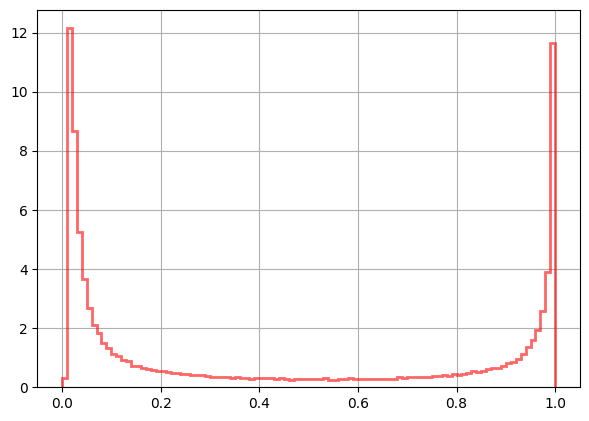

In [24]:
#print output_SM
#print output_BSM
bins=100
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.hist(output_SM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="red",
        alpha=0.6,
        linewidth=2,
        label="SM Output",)                        
ax.hist(output_BSM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="blue",
        alpha=0.6,
        linewidth=2,
        label="BSM Output",)                        
plt.rc('legend',fontsize='small')    
plt.show()

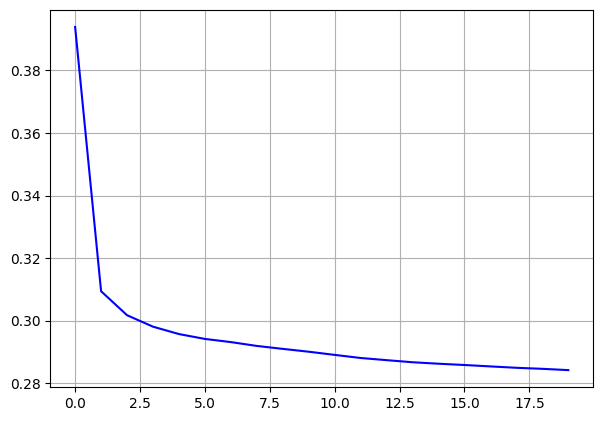

In [25]:
x_bins = range(len(hist.history["loss"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,hist.history["loss"],color="blue",label="training losss")                        
plt.rc('legend',fontsize='small')    
plt.show()